
# 实现线性回归

In [97]:
import random
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import torch
%matplotlib inline

## 生成数据集

In [98]:
num_inputs = 2 # 输入特征数 2
num_examples = 1000 # 1000个样本
true_w = [2, -3.4]  # 线性回归的真实权重
true_b = 4.2   # 偏差

# 100 row 2 col
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)

labels = true_w[0] * features[:,0] + true_w[1] * features[:, 1] + true_b    # 这里不要忘记把偏差加上

# 噪声项 服从 均值为 0  标准差为 0.01 的正态分布  噪声项代表无意义的干扰
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

print(features[0], labels[0])   # 查看结构

tensor([-0.4718,  1.9586]) tensor(-3.3983)


C:\Users\zonglin\AppData\Local\Temp/ipykernel_51176/942839298.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


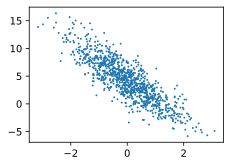

In [99]:
def use_svg_display():
    # 使用 svg 展示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:,1].numpy(), labels.numpy(), 1)

## 读取数据

In [100]:
# 训练模型时 需要遍历数据集并不断读取小批量数据样本
# 该函数每次返回 batch_size 批量大小个随机样本的特征和标签 也就是把样本分成 batch_size 份
def data_iter(batch_size, features, labels):
    num_examples = len(features)            # 获取样本总数
    indices = list(range(num_examples))     # 生成样本总数的一个索引 例如 [0,1,2,...,num_example-1]
    # print("indices:", indices)
    random.shuffle(indices)                 # 样本读取顺序是随机的 所以使用 shuffle 进行打乱
    for i in range(0, num_examples, batch_size):    # 步长为 batch_size
        # j 是一个序列 由于 indices 已经打乱 所以可以顺序截取
        j = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])   # 最后一次可能不足一个batch
        # print(j)    # 如 [761, 432, 254, 417, 367,   6, 540, 955, 328,  15]
        yield features.index_select(0, j), labels.index_select(0, j)

In [101]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.2197, -2.1488],
        [ 0.8090, -0.4557],
        [ 0.8199,  0.9091],
        [ 1.7475, -0.6336],
        [ 0.8773, -1.3141],
        [-0.3836, -1.3116],
        [-0.6887,  0.9302],
        [-1.6018, -0.8304],
        [ 2.9051, -0.8173],
        [ 1.6569,  1.0987]]) tensor([11.9348,  7.3637,  2.7414,  9.8650, 10.4066,  7.8861, -0.3378,  3.8208,
        12.7888,  3.7840])


## 初始化模型参数

In [102]:
# 权重初始化为： 均值 0  标准差 0.01 的正态随机数 偏差初始化为0
# 权重为 2 行 1 列 (num_inputs, 1) 对应要输入两个特征
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
print(w)
print(b)

tensor([[ 0.0038],
        [-0.0251]])
tensor([0.])


之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的`requires_grad=True`。

In [103]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

## 定义模型
下面是线性回归的矢量计算表达式的实现。我们使用`mm`函数做矩阵乘法。

In [104]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

## 定义损失函数
使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值y变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [105]:
def square_loss(y_hat, y):
    # 这里返回的是向量 pytorch 中 MSELoss 没有除以2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 定义优化算法
实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [106]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size  # 注意这里更改param时用的param.data

## 模型训练
多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失l的形状为(10, 1)。回忆一下自动求梯度一节。由于变量l并不是一个标量，所以我们可以调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，**大多超参数都需要通过反复试错来不断调节**。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [107]:
lr = 0.03       # 学习率
num_epochs = 3  # 迭代轮次
net = linreg
loss = square_loss

for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。
    # X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum() # l是有关小批量X和y的损失
        l.backward()                    # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)     # 使用小批量随机梯度下降迭代模型参数 每次迭代中更新权重和偏差

        # 不要忘记 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.037160
epoch 2, loss 0.000130
epoch 3, loss 0.000048


In [108]:
# 训练完成后，可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9989],
        [-3.3993]], requires_grad=True)
4.2 
 tensor([4.1991], requires_grad=True)


# 简洁的实现线性回归
使用PyTorch

### 生成数据集

In [109]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2

# 生成特征
# 均值为 0 标准差为 1 的正态分布 数组结构为 (num_example, num_inputs) 类型为 float64
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)

# 为每个样本构造标签
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b


### 读取数据
PyTorch提供了`data`包来读取数据。由于`data`常用作变量名，我们将导入的`data`模块用`Data`代替。在每一次迭代中，我们将随机读取包含10个数据样本的小批量。

In [110]:
import torch.utils.data as Data

# 每一批读取10个样本的小批量数据
batch_size = 10
# 组合训练数据的特征和标签
dataset = Data.TensorDataset(features, labels)
# 随机小批量读取
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)
for X, y in data_iter:
    print(X, y)
    break

tensor([[-0.5807,  0.5338],
        [ 0.6162,  1.2615],
        [ 1.5956, -0.1802],
        [ 0.3294,  0.6714],
        [ 2.3733,  0.0138],
        [-1.5177,  1.0574],
        [-1.5049,  0.2796],
        [-0.2071, -1.3819],
        [ 2.3059, -0.3240],
        [-2.7423, -1.2921]]) tensor([ 1.2238,  1.1432,  8.0038,  2.5759,  8.8997, -2.4306,  0.2397,  8.4845,
         9.9134,  3.1087])


### 定义模型
PyTorch提供了大量预定义的层，这使我们只需关注使用哪些层来构造模型。下面将介绍如何使用PyTorch更简洁地定义线性回归。
导入`torch.nn`模块。实际上，“nn”是neural networks（神经网络）的缩写。顾名思义，该模块定义了大量神经网络的层。之前我们已经用过了`autograd`，而`nn`就是利用`autograd`来定义模型。`nn`的核心数据结构是`Module`，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承`nn.Module`，撰写自己的网络/层。一个`nn.Module`实例应该包含一些层以及返回输出的前向传播（forward）方法。下面先来看看如何用`nn.Module`实现一个线性回归模型。

In [111]:
import torch.nn as nn    # neural networks

class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)

    # 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y


net = LinearNet(num_inputs)
print(net)  # 打印网络结构


LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


还可以用`nn.Sequential`来更加方便地搭建网络，`Sequential`是一个有序的容器，网络层将按照在传入`Sequential`的顺序依次被添加到计算图中。

In [112]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 还可以传入其他层
)

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module 还可以继续添加module

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(num_inputs, 1))
    # ... 可以继续加
]))

print(net)
print(net[0])


Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


可以通过`net.parameters()`来查看模型所有的可学习参数，此函数将返回一个生成器

In [113]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.6613, -0.4438]], requires_grad=True)
Parameter containing:
tensor([0.5312], requires_grad=True)


### 初始化模型参数
在使用net前，我们需要初始化模型参数，如线性回归模型中的权重和偏差。PyTorch在init模块中提供了多种参数初始化方法。这里的init是initializer的缩写形式。我们通过`init.normal_`将权重参数每个元素初始化为随机采样于均值为0、标准差为0.01的正态分布。偏差会初始化为零。

In [114]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)   # net[0]的写法是由于这个net是由nn.Sequential()定义的
init.constant_(net[0].bias, val=0)

# init.normal_(net.linear.weight, mean=0, std=0.01)
# init.normal_(net.linear.bias, 0)

Parameter containing:
tensor([0.], requires_grad=True)

### 定义损失函数
PyTorch在nn模块中提供了各种损失函数，这些损失函数可看作是一种特殊的层，PyTorch也将这些损失函数实现为`nn.Module`的子类。我们现在使用它提供的均方误差损失作为模型的损失函数。

In [115]:
loss = nn.MSELoss()

### 定义优化算法
同样，我们也无须自己实现小批量随机梯度下降算法。`torch.optim`模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等。下面我们创建一个用于优化net所有参数的优化器实例，并指定学习率为0.03的小批量随机梯度下降（SGD）为优化算法。

In [116]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


还可以为不同子网络设置不同的学习率，这在finetune时经常用到。
```python
optimizer = optim.SGD([
    # 如果对某个参数不指定学习率，就使用最外层的默认学习率
    {'params': net.subnet1.parameters()},   # lr=0.03   可以用 net[i] 表示第i个网络
    {'params': net.subnet2.parameters(), 'lr': 0.01},   # lr=0.01
], lr=0.03)
print(optimizer)
```
此外可以让学习率变化，进行调整

In [117]:
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1

### 训练模型
通过调用optim实例的step函数来迭代模型参数。按照小批量随机梯度下降的定义，我们在step函数中指明批量大小，从而对批量中样本梯度求平均。

In [120]:
num_epochs = 3
for epoch in range (1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000099
epoch 2, loss: 0.000031
epoch 3, loss: 0.000006


### 评估模型

In [121]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.9987, -3.3984]], requires_grad=True)
4.2 Parameter containing:
tensor([4.1980], requires_grad=True)
